Imports

In [2]:
from numba import cuda
import numpy as np
from PIL import Image
from matplotlib import pyplot
import math

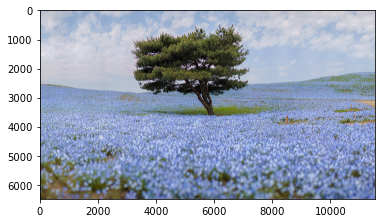

In [3]:
image = Image.open('../images/Tree.jpg')
pyplot.imshow(image)

In [4]:
def conv_to_gray(data):
    gray = np.dot(data[...,:3],[0.2989, 0.5870, 0.1140])
    return gray


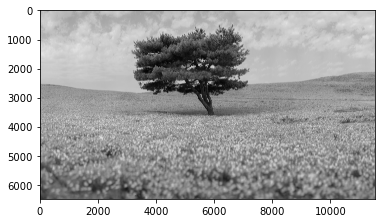

In [5]:
rgb_image = np.array(image)
gray_image = conv_to_gray(rgb_image)
pyplot.imshow(Image.fromarray(gray_image))

GPU Kernel

In [10]:
@cuda.jit
def bw_kernel(d_rgb_image, d_gray_image):
    i,j = cuda.grid(2)
    if i < d_rgb_image.shape[0] and j < d_rgb_image.shape[1]:
        d_gray_image[i,j] = 0.2989*d_rgb_image[i,j,0] + 0.5870*d_rgb_image[i,j,1] + 0.1140*d_rgb_image[i,j,2]
    return

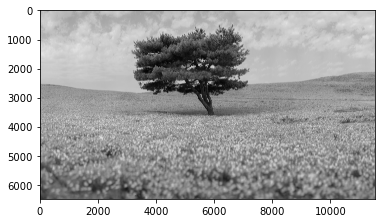

In [16]:
# transferring the 2 arrays to the device memory explicitly
d_rgb_image = cuda.to_device(rgb_image)
d_gray_image = cuda.device_array(rgb_image.shape[0:2])

# Setting dimensions with which to invoke the cuda kernel
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(rgb_image.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(rgb_image.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
# Running the kernel
bw_kernel[blockspergrid, threadsperblock](d_rgb_image, d_gray_image)
# Copying to device array to host array
gray_image = Image.fromarray(d_gray_image.copy_to_host())
pyplot.imshow(gray_image)